# Flag outliers from time series
* 

In [31]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
def fit_data(y: np.array, 
             frac:float = 0.05) -> np.array:
    '''Fit a LOWESS regression and return predicted values'''
    x = np.linspace(0, len(y)-1, num=len(y)
    return sm.nonparametric.lowess(y, x, frac=frac, return_sorted=False)

SyntaxError: invalid syntax (<ipython-input-32-fec44b16529b>, line 5)

In [33]:
def identify_outliers(df: pd.DataFrame,
                   y_col: str,
                   y_pred: str,
                   lower_prob:float = 0.25, 
                   upper_prob:float = 0.75) -> np.array:
    '''Compute outlier score given predicted values'''

    residuals = df[y_col] - df[y_pred]

    # percentiles and interquartile range
    ptiles = np.array([
        np.percentile(residuals.values, 25), 
        np.percentile(residuals.values, 75)
    ])
    iqr = ptiles[1] - ptiles[0]

    limits = ptiles + 1.5*iqr*np.array([-1, 1])
    
    # Create column containing score
    df['outlier_score'] = np.abs(np.minimum((residuals - limits[0]) / iqr, 0) +
                                 np.maximum((residuals - limits[1]) / iqr, 0))

    return df

In [34]:
def predict_and_score(df:pd.DataFrame,
                      group_col:str,
                      y_col:str,
                      y_pred:str) -> pd.DataFrame:
    '''Given df, for each generate predicted y given model and
    generate outlier scores
    '''
    df['y_pred'] = (df.groupby(group_col)[y_col].
                    transform(fit_data))
    return (df.groupby(group_col).
            apply(identify_outliers, y_col='y', y_pred='y_pred'))

In [35]:
def plot_ts(y, y_pred, x, score):
    '''Plot timeseries and outlier for each group'''
    plt.clf()
    score_plot = np.where(score>0, y, np.nan)
    sns.lineplot(x, y)
    sns.lineplot(x, y_pred)
    sns.scatterplot(x, score_plot, color="#F81919")
    plt.show()

In [36]:
def fake_data():
    '''Create fake panel data for demonstration'''
    df_list = []
    mu = 4
    for i in range(10):
        y = mu + np.random.normal(loc=0, scale=3, size=100)
        x = np.linspace(0, 99, num=100)
        dl = {'group': [i]*len(y), 'time': x, 'y': y}
        data = pd.DataFrame(dl, columns=['group', 'time', 'y'])
        df_list.append(data)
    return pd.concat(df_list)

In [37]:
df = fake_data()
display(df.head(), df.tail())

,group,time,y
0,0,0.0,3.909936
1,0,1.0,3.181996
2,0,2.0,7.003873
3,0,3.0,4.225137
4,0,4.0,5.371487


,group,time,y
95,9,95.0,2.073880
96,9,96.0,3.525796
97,9,97.0,-0.194400
98,9,98.0,0.749500
99,9,99.0,3.701754


In [38]:
dff = predict_and_score(df, 'group', 'y', 'y_pred')
dff.head()

,group,time,y,y_pred,outlier_score
0,0,0.0,3.909936,3.531967,0.0
1,0,1.0,3.181996,4.386980,0.0
2,0,2.0,7.003873,5.059882,0.0
3,0,3.0,4.225137,5.333078,0.0
4,0,4.0,5.371487,4.369217,0.0


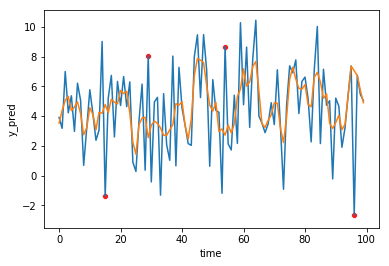

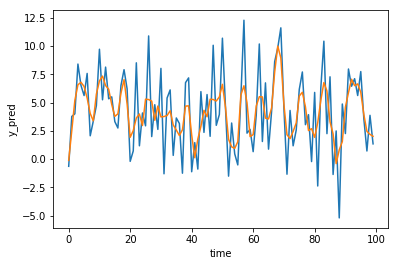

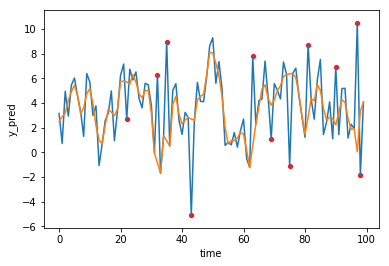

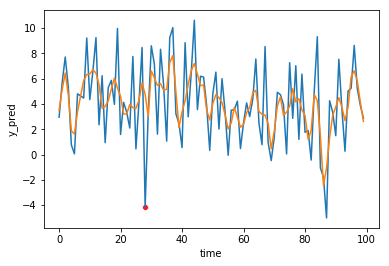

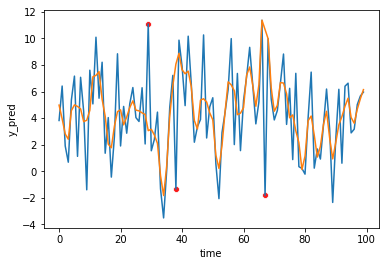

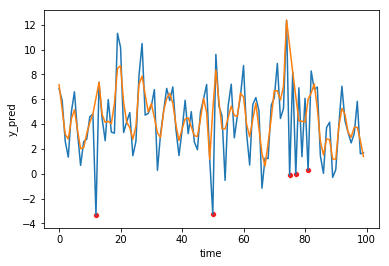

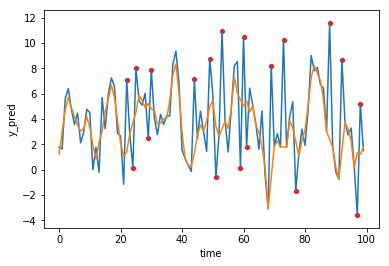

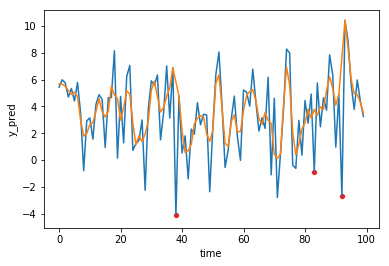

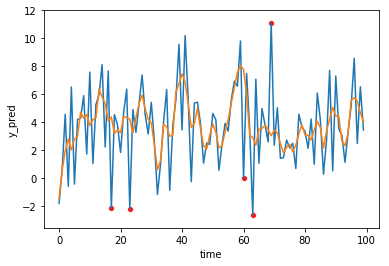

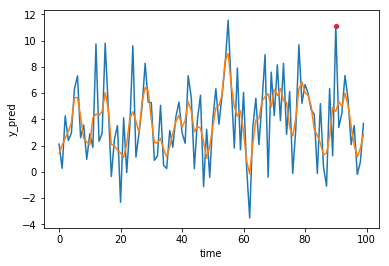

In [39]:
for g in dff.group.unique():

    dff_sub = dff[dff.group == g]
    score = dff_sub.outlier_score
    x = dff_sub.time
    y = dff_sub.y
    y_pred = dff_sub.y_pred

    plot_ts(y, y_pred, x, score)